# Movie Review Classification:

In [4]:
# Importing necessary libraries
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Importing models

from sklearn.linear_model import LogisticRegression # classification - Larger dataset
from sklearn.naive_bayes import MultinomialNB # categorical input variables - Smaller dataset

from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV # cross-validation
from sklearn.metrics import  accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer # word count; tf = term frequency
from collections import Counter

import warnings;
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis (EDA)
- As we see below, it is a textual data with 50,000 rows and 2 columns: review and sentiment.
- The task is to perform sentiment analysis on the data.
- This will be a supervised binary text classification task as the data is labelled (sentiments) and textual (reviews). 

In [5]:
df_ = pd.read_csv('imdb.csv')
df = df_.copy()

# Shape = (rows, columns)

print(df.shape)

# Display the first 5 rows of the data

print(df.head())

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Finding the NaN (missing values) and removing the duplicates so that our data is complete and unique.

In [31]:
def is_nan(df):
    return df.isna().sum()

# Removing duplicates

def make_unique(df):
    df_unique = df.drop_duplicates()
    return(df_unique)

print('\n NaN counts of columns:\n', is_nan(df))
print('\n Shape of the unique dataset is: ', make_unique(df).shape)


 NaN counts of columns:
 review       0
sentiment    0
dtype: int64

 Shape of the unique dataset is:  (49573, 2)


### The distribution of each label in the data as an unbalanced dataset.
- It might cause false modelling if it's not handled accordingly.

(49573, 2)


[Text(0.5, 1.0, 'Number of entries in each sentiment')]

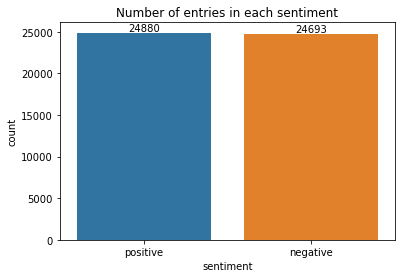

In [32]:
df = make_unique(df)
print(df.shape)

# Count Vs Sentiment

ax = sns.countplot(x=df['sentiment'])
ax.bar_label(ax.containers[0])
ax.set(title='Number of entries in each sentiment')

### Text Preprocessing 
It will clean the data from unnecessary attributes of texts that does not help the classification algorithm.
<br>  
This preprocessing part will include 4 steps -
- Get rid of HTML expression and any special characters.
- Convert all letters to lower-case.
- Get rid of stopwords: These are commonly used in a natural language yet are insignificant in terms of the context such as 'it', 'I' or 'an' etc. 
- Stemming: It will allow the words coming from the same root, such as happy and happier, to be understood as the same entity which in the end will result in better model performance. 

In [11]:
# Get stopwords and initialize stemmer - trimming down words to their stems

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

In [33]:
# Preprocessing 
# Text Cleaning

def preprocess(review):
    # step-1: Remove special characters
    review = BeautifulSoup(review).get_text()
    regex = re.compile('[^a-zA-Z]')
    review = regex.sub(' ', review)
    # step-2: Lower all the letters
    review = review.lower()
    # step-3: Remove the stopwords and stem 
    review = " ".join(ps.stem(word) for word in review.split() if word not in stopwords)
    return(review)

review = df.review[0]
print(preprocess(review))

# This process is only for 1 review

review mention oz episod hook right exactli happen struck oz brutal unflinch violenc set right word trust faint heart timid pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focu mainli emerald citi experi section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement far away main appeal due fact goe dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around episod ever saw struck nasti surreal readi develop tast oz got accustom high level graphic violenc violenc injust crook guard sold nickel inmat kill order away manner middl class inmat turn prison bitch due lack street skill prison experi oz may becom comfort uncomfort view touch darker side


### Above, we see how a single review is transformed after preprocessing.
- There are no punctuations and words, or sentences doesn't necessarily mean anything.

### Now we will apply the same preprocessing function to all the reviews.

In [34]:
# Apply preprocessing to all the reviews

df['review'] = df['review'].map(lambda x: preprocess(x))
df.head

# Time_Taken = 1 minute 30 seconds

<bound method NDFrame.head of                                                   review sentiment
0      review mention oz episod hook right exactli ha...  positive
1      wonder product techniqu unassum old bbc fashio...  positive
2      thought wonder spend hot summer weekend sit ai...  positive
3      basic famili boy jake zombi closet parent figh...  negative
4      petter mattei love money visual stun mr mattei...  positive
...                                                  ...       ...
49995  thought right job creativ origin expect whole ...  positive
49996  bad plot bad dialogu bad idiot direct annoy po...  negative
49997  cathol taught parochi elementari school nun ta...  negative
49998  disagr previou comment side maltin second rate...  negative
49999  expect star trek high art fan expect best epis...  negative

[49573 rows x 2 columns]>

### Distribution of most common terms in each label.

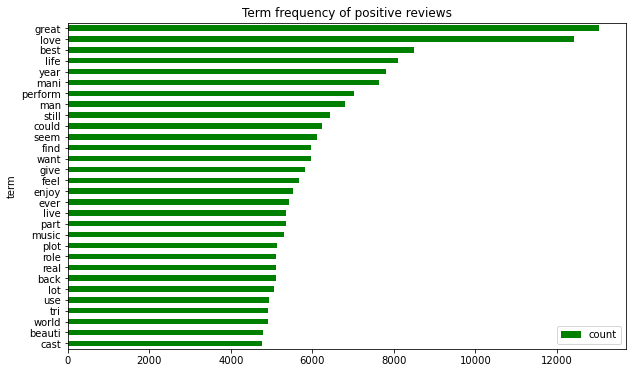

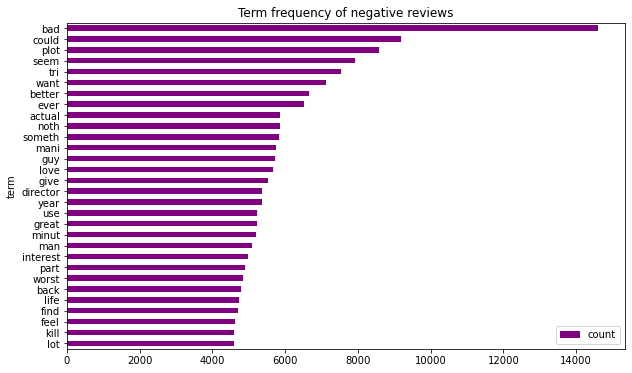

In [35]:
# Positive reviews ---

df_pos = df.loc[df['sentiment'] == 'positive']
pos = ' '.join(df_pos.review).split()

# Get most common 30 term's counts into a dataframe

pos_term_freq = pd.DataFrame(Counter(pos).most_common(30), columns=['term', 'count'])

# Plot positive term frequencies

fig, ax = plt.subplots(figsize=(10, 6))
pos_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color="green")
ax.set_title("Term frequency of positive reviews")
plt.show()

# Negative reviews ---

df_neg = df.loc[df['sentiment'] == 'negative']
neg = ' '.join(df_neg.review).split()

# Get most common 30 term's counts into a dataframe

neg_term_freq = pd.DataFrame(Counter(neg).most_common(30), columns=['term', 'count'])

# Plot negative term frequencies

fig, ax = plt.subplots(figsize=(10, 6))
neg_term_freq.sort_values(by='count').plot.barh( x='term', y='count', ax=ax, color="purple")
ax.set_title("Term frequency of negative reviews")
plt.show()

In [37]:
# Find the number of terms that occurred in both sentiments

common_terms = set(pos_term_freq.term) & set(neg_term_freq.term)
print('\nThe number of terms that occurred in both sentiments top 30 terms:', len(common_terms))


The number of terms that occurred in both sentiments top 30 terms: 19


In [38]:
# Remove common terms for 1 review

def remove_common(review):
    return(" ".join(word for word in review.split() if word not in common_terms))

df['review'] = df['review'].map(lambda x: remove_common(x))

In [39]:
# Remove common terms for all the reviews

print('\nTotal Word-Count:', df['review'].apply(lambda x: len(x.split(' '))).sum())
all_terms = ' '.join(df.review).split()
print('Total number of unique terms:', len(set(all_terms)) )


Total Word-Count: 4586945
Total number of unique terms: 69949


# 2. Modelling
- In this section we will compare two common text classification algorithms:
    * Naive Bayes as nb
    * Logistic Regression as logreg
<br>
<br>
- We will also tune the hyper-parameters via Gridsearch and compare both models with their best parameters. 
<br>

- At first, We start with splitting the dataset into 'Training' and 'Test' sets.
    * Splitting the data into 80:20 ratio.

In [41]:
# Train-Test Split
 
X = df.review
y = df.sentiment

# At 0.2 means 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)

print('\nSize of Training set: ',len(X_train))
print('Size of Test set: ',len(X_test))


Size of Training set:  39658
Size of Test set:  9915


### Now we will train both models initially with training set.

## i) Naive Bayes as nb 

In [42]:
nb = Pipeline([('vect', TfidfVectorizer(max_features=5000)), 
                ('clf', MultinomialNB())])
 
nb.fit(X_train, y_train)

# Tunning of Naive Bayes Classifier

param={'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
gs_nb = GridSearchCV(nb,param,scoring='accuracy',cv=10)
gs_nb.fit(X_train, y_train)

print('\nBest Score:', gs_nb.best_score_)
#print('Best alpha:', gs_nb.best_params_)

# Time_Taken = 4 minutes 20 seconds

Best Score: 0.8512026182195573


## ii) Logistic Regression as logreg

In [43]:
# Logistic Regression as logreg

logreg = Pipeline([('vect', TfidfVectorizer(max_features=5000)), 
                   ('clf', LogisticRegression())])
 
logreg.fit(X_train, y_train)

# Tunning of hyper-parameters of Logistic Regression Classifier

param= {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
gs_logreg = GridSearchCV(logreg,param,scoring='accuracy',cv=10)
gs_logreg.fit(X_train, y_train)

print('\nBest Score:', gs_logreg.best_score_)
#print('Best parameters:', gs_logreg.best_params_)

# Time_Taken = 28 minutes 25 seconds


Best score: 0.8814109845413632


> Best Score of NB = 85.12 %

> Best Score of LR = 88.14 %

## 3. Results  
- We can see the training and test set accuracies of both models in the following.
- Also test accuracies are slightly less than training accuracies because of tunning.

In [44]:
# Results of Naive Bayes:

print('Training Accuracy of Naive Bayes:', round(accuracy_score(y_train, gs_nb.predict(X_train)),3))
print('Test Accuracy of Naive Bayes:', round(accuracy_score(y_test, gs_nb.predict(X_test)),3))

print('\n')

# Results of Logistic Regression:

print('Training Accuracy of Logistic Regression:', round(accuracy_score(y_train, gs_logreg.predict(X_train)),3))
print('Test Accuracy of Logistic Regression:', round(accuracy_score(y_test, gs_logreg.predict(X_test)),3))

Training Accuracy of Naive Bayes: 0.86
Test Accuracy of Naive Bayes: 0.848


Training Accuracy of Logistic Regression: 0.908
Test Accuracy of Logistic Regression: 0.875


Hence,
- Accuracy of Logistic Regression is 0.908 compared to 0.857 accuracy on the test set.
<br>
<br>
- Accuracy of Naive Bayes is 0.86 compared to 0.848 accuracy on the test set.

### So, this conclude that Logistic Regression has maximum accuracy.